<a href="https://colab.research.google.com/github/kachmaryk/computer_vision/blob/main/lab_3/lab_3_raw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

import time
import os
import copy
import cv2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
batch_size = 16

# transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                      std=[0.229, 0.224, 0.225])


# MB add to train transforms
# transforms.RandomCrop(32, padding=4),
# transforms.RandomHorizontalFlip(),

# mean = 0.2860347330570221
# std = 0.3530242443084717

transform = transforms.Compose([transforms.Resize(256),
                              transforms.CenterCrop(224),
                              transforms.ToTensor(),
                              transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                              transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                   std=[0.229, 0.224, 0.225]),
                              ])

train_set = torchvision.datasets.FashionMNIST("./data",
                                              download=True,
                                              transform=transform)

train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=4)

test_set = torchvision.datasets.FashionMNIST("./data",
                                             download=True,
                                             train=False,
                                             transform=transform)

test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=4) 

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [3]:
train_set

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Lambda()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [4]:
img, label = train_set[10]
img.size()

torch.Size([3, 224, 224])

9 - Ankle boot


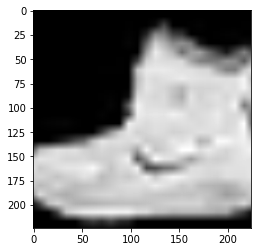

In [5]:
image, label = next(iter(train_set))
# image.squeeze()[0]
plt.imshow(image.squeeze()[0], cmap="gray")
print(label, '-', train_set.classes[label])

In [6]:
train_set.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
train_loader

In [8]:
# Examine a sample
data_iter = iter(train_loader)
images, labels = data_iter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([16, 3, 224, 224])
torch.Size([16])


In [9]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [10]:
num_epochs = 3
num_classes = len(train_set.classes)
feature_extract = True

In [11]:
if feature_extract:
  for param in model.parameters():
    param.requires_grad = False

# num_ftrs = model.classifier.in_features
# model.classifier = nn.Linear(num_ftrs, num_classes)
# input_size = 224

In [12]:
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, num_classes)

model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [13]:
# Send the model to GPU
model = model.to(device)

In [14]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.

params_to_update = model.parameters()
print("Params to learn:")

if feature_extract:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.weight
	 classifier.bias


In [15]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

since = time.time()

train_acc_history = []
val_acc_history = []

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
  print('Epoch {}/{}'.format(epoch, num_epochs - 1))
  print('-' * 10)

  # Train and validate each epoch
  for phase in ['train', 'val']:
    if phase == 'train':
      model.train()  # Set model to training mode

      data_loader = train_loader
    else:
      model.eval()   # Set model to evaluate mode

      data_loader = test_loader

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in tqdm(data_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward
      # track history if only in train
      with torch.set_grad_enabled(phase == 'train'):
        # Get model outputs and calculate loss

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        
        # backward + optimize only in training phase
        if phase == 'train':
          loss.backward()
          optimizer.step()
      
      # statistics
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = running_corrects.double() / len(data_loader.dataset)

    print('{} Loss: {:.4f} Acc: {:.4f}\n\n'.format(phase, epoch_loss, epoch_acc))

    # deep copy the model
    if phase == 'val' and epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model_wts = copy.deepcopy(model.state_dict())
    
    if phase == 'val':
      val_acc_history.append(epoch_acc)
    else:
      train_acc_history.append(epoch_acc)

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

# load best model weights
model.load_state_dict(best_model_wts)

Epoch 0/2
----------


100%|██████████| 3750/3750 [02:14<00:00, 27.92it/s]


train Loss: 0.6517 Acc: 0.7830




100%|██████████| 625/625 [00:20<00:00, 30.01it/s]


val Loss: 0.5034 Acc: 0.8249


Epoch 1/2
----------


100%|██████████| 3750/3750 [02:16<00:00, 27.50it/s]


train Loss: 0.5034 Acc: 0.8238




100%|██████████| 625/625 [00:20<00:00, 29.87it/s]


val Loss: 0.4606 Acc: 0.8297


Epoch 2/2
----------


100%|██████████| 3750/3750 [02:16<00:00, 27.46it/s]


train Loss: 0.4846 Acc: 0.8279




100%|██████████| 625/625 [00:21<00:00, 29.66it/s]


val Loss: 0.4333 Acc: 0.8427


Training complete in 7m 50s
Best val Acc: 0.842700


<All keys matched successfully>

Training accuracy [0.783 0.824 0.828]
Validation accuracy [0.825 0.83  0.843]


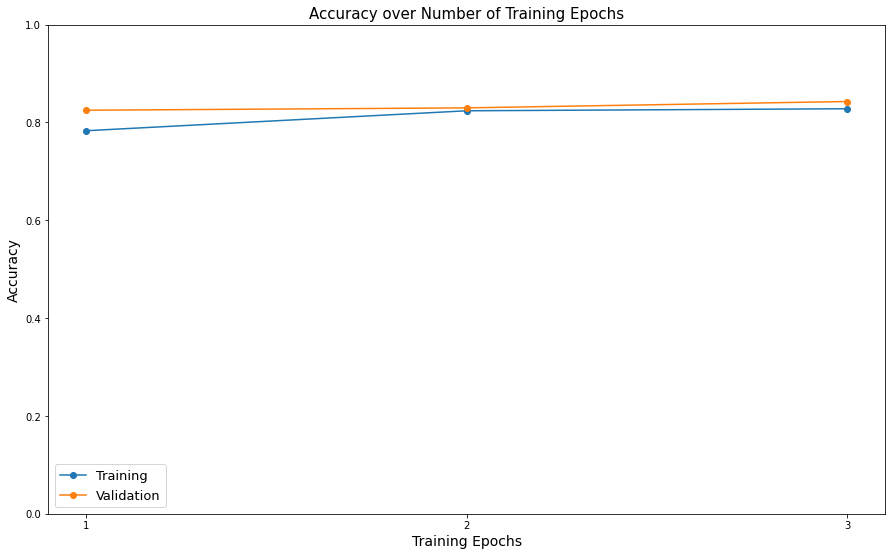

In [56]:
train_hist = [h.cpu().numpy() for h in train_acc_history]
val_hist = [h.cpu().numpy() for h in val_acc_history]

print('Training accuracy', np.around(np.array(train_hist), 3).reshape(len(train_hist),))
print('Validation accuracy', np.around(np.array(val_hist), 3).reshape(len(val_hist),))

plt.figure(figsize=(15, 9))
plt.title("Accuracy over Number of Training Epochs", fontsize=15)
plt.xlabel("Training Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)

plt.plot(range(1, num_epochs+1), train_hist, label="Training", marker = 'o')
# for a, b in zip(range(1, num_epochs+1), train_hist): 
#     plt.text(a, b, str(np.around(b, 2)))
plt.plot(range(1, num_epochs+1), val_hist, label="Validation", marker = 'o')
# for a, b in zip(range(1, num_epochs+1), val_hist): 
#     plt.text(a, b, str(np.around(b, 2)))
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend(loc='lower left', fontsize=13)
plt.show()

In [70]:
test_labels = []
predict_labels = []

for inputs, labels in tqdm(data_loader):
  test_labels.extend(list(labels.detach().cpu().numpy()))

  inputs = inputs.to(device)
  labels = labels.to(device)

  predicted = model(inputs)
  _, preds = torch.max(predicted, 1)
  predict_labels.extend(list(preds.detach().cpu().numpy()))

print(test_labels)
print(predict_labels)

100%|██████████| 625/625 [00:21<00:00, 29.18it/s]

[9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9, 1, 4, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1, 2, 2, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5, 1, 1, 2, 3, 9, 8, 7, 0, 2, 6, 2, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2, 0, 6, 5, 3, 6, 7, 1, 8, 0, 1, 4, 2, 3, 6, 7, 2, 7, 8, 5, 9, 9, 4, 2, 5, 7, 0, 5, 2, 8, 6, 7, 8, 0, 0, 9, 9, 3, 0, 8, 4, 1, 5, 4, 1, 9, 1, 8, 6, 2, 1, 2, 5, 1, 0, 0, 0, 1, 6, 1, 6, 2, 2, 4, 4, 1, 4, 5, 0, 4, 7, 9, 3, 7, 2, 3, 9, 0, 9, 4, 7, 4, 2, 0, 5, 2, 1, 2, 1, 3, 0, 9, 1, 0, 9, 3, 6, 7, 9, 9, 4, 4, 7, 1, 2, 1, 6, 3, 2, 8, 3, 6, 1, 1, 0, 2, 9, 2, 4, 0, 7, 9, 8, 4, 1, 8, 4, 1, 3, 1, 6, 7, 2, 8, 5, 2, 0, 7, 7, 6, 2, 7, 0, 7, 8, 9, 2, 9, 0, 5, 1, 4, 4, 5, 6, 9, 2, 6, 8, 6, 4, 2, 2, 9, 7, 6, 5, 5, 2, 8, 5, 2, 3, 0, 4, 8, 0, 0, 6, 3, 8, 9, 6, 1, 3, 0, 2, 3, 0, 8, 3, 7, 4, 0, 1, 6, 3, 0, 6, 6, 7, 5, 4, 5, 9, 5, 6, 5, 5, 1, 9, 8, 8, 3, 3, 6, 8, 0, 0, 2, 9, 7, 7, 1, 3, 6, 4, 2, 4, 9, 1, 6, 4, 8, 2, 6, 5, 4, 6, 7, 7, 7, 3, 3, 7, 0, 

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools

multilabel_confusion_matrix(test_labels,
                            predict_labels, 
                            labels=list(train_set.classes))

In [109]:
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_test, y_scores, classNames):
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("\n**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))

plot_confusion_matrix(test_labels,
                      predict_labels,
                      list(train_set.classes)) 

**** Confusion Matrix ****
[[770   6  62  45  13   2  92   0  10   0]
 [  1 951   8  18   5   0  14   0   3   0]
 [  9   1 845   6  59   0  79   0   1   0]
 [ 16  24  20 831  41   1  64   0   2   1]
 [  1   3 127  41 717   0 110   0   1   0]
 [  0   1   2   1   0 910   1  64   3  18]
 [128   5 131  38 103   0 578   0  17   0]
 [  0   0   0   0   0  15   0 940   1  44]
 [  2   1  15  12   7   5  13   1 943   1]
 [  0   0   0   4   0   9   0  39   6 942]]

**** Classification Report ****
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.77      0.80      1000
     Trouser       0.96      0.95      0.95      1000
    Pullover       0.70      0.84      0.76      1000
       Dress       0.83      0.83      0.83      1000
        Coat       0.76      0.72      0.74      1000
      Sandal       0.97      0.91      0.94      1000
       Shirt       0.61      0.58      0.59      1000
     Sneaker       0.90      0.94      0.92      1000
         Bag       0.9

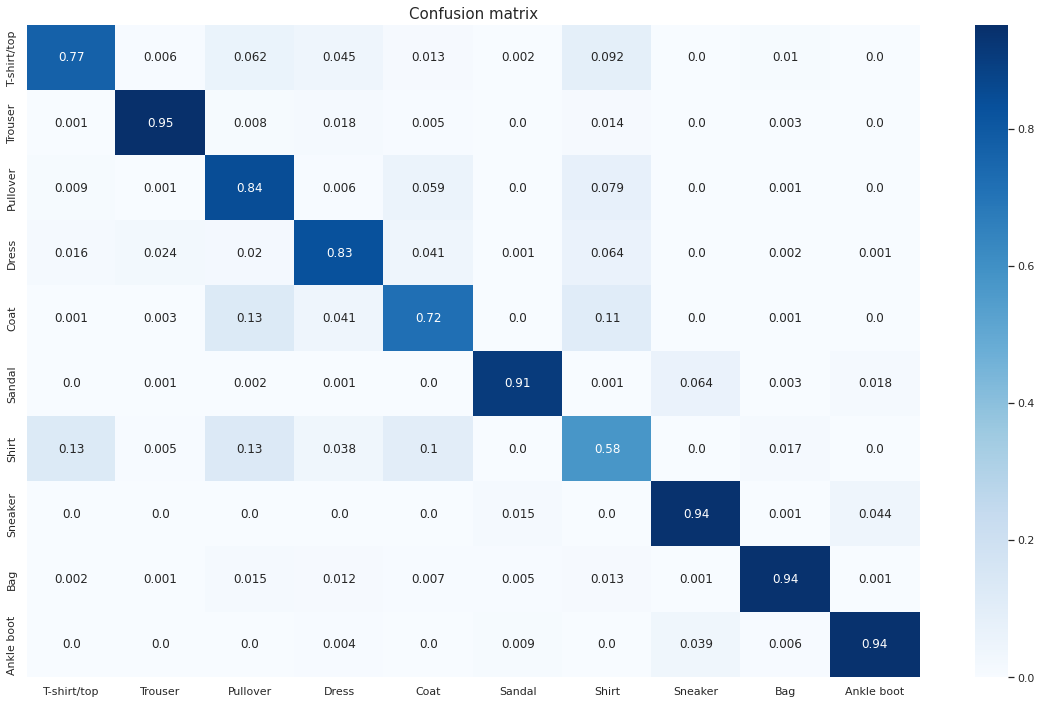

In [115]:
cm = confusion_matrix(test_labels,
                      predict_labels)

con = np.zeros((len(train_set.classes), len(train_set.classes)))
for x in range(len(train_set.classes)):
    for y in range(len(train_set.classes)):
        con[x,y] = cm[x,y]/np.sum(cm[x,:])

plt.figure(figsize=(20,12))
plt.title("Confusion matrix", fontsize=15)
sns.set(font_scale=1.0) # for label size
sns.heatmap(con, annot=True, fmt='.2', cmap='Blues',
            xticklabels=train_set.classes,
            yticklabels=train_set.classes)
plt.show()